In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import re
from dataclasses import dataclass
from typing import Optional, Tuple
from numpy.typing import NDArray
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from snsphd.viz import phd_style
from snsphd.layout import bisect

colors, swatches = phd_style(jupyterStyle=True)




In [2]:
@dataclass
class ScopeTraceData:
    """Data structure for scope trace information"""
    filename: str
    time_data: NDArray[np.float64]
    amplitude_data: NDArray[np.float64]
    crop_left: Optional[float] = None
    crop_right: Optional[float] = None
    
    def get_cropped_data(self) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
        """
        Get time and amplitude data with optional cropping applied.
        crop_left and crop_right are durations to remove from the start and end respectively.
        
        Returns:
            Tuple of (time_data, amplitude_data) with cropping applied
        """
        if self.crop_left is None and self.crop_right is None:
            return self.time_data, self.amplitude_data
            
        # Calculate absolute time boundaries based on offsets from ends
        time_min = self.time_data.min()
        time_max = self.time_data.max()
        
        # Determine the actual time boundaries
        left_boundary = time_min + (self.crop_left if self.crop_left is not None else 0)
        right_boundary = time_max - (self.crop_right if self.crop_right is not None else 0)
        
        # Create mask for the cropped region
        mask = (self.time_data >= left_boundary) & (self.time_data <= right_boundary)
            
        return self.time_data[mask], self.amplitude_data[mask]
    
def load_scope_trace(filepath: str, 
                    crop_left: Optional[float] = None,
                    crop_right: Optional[float] = None) -> ScopeTraceData:
    """
    Load scope trace data from LeCroy oscilloscope format file.
    
    Args:
        filepath: Path to the scope trace file
        crop_left: Optional duration to crop from the start of the time array (in seconds)
        crop_right: Optional duration to crop from the end of the time array (in seconds)
        
    Returns:
        ScopeTraceData object containing parsed data
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Find data start (after "Time,Ampl" header)
    data_start_idx = None
    for i, line in enumerate(lines):
        if line.strip() == "Time,Ampl":
            data_start_idx = i + 1
            break
    
    if data_start_idx is None:
        raise ValueError("Could not find data section in file")
    
    # Parse time and amplitude data
    time_data = []
    amplitude_data = []
    
    for line in lines[data_start_idx:]:
        line = line.strip()
        if line and ',' in line:
            parts = line.split(',')
            if len(parts) >= 2:
                try:
                    time_val = float(parts[0])
                    amp_val = float(parts[1])
                    time_data.append(time_val)
                    amplitude_data.append(amp_val)
                except ValueError:
                    # Skip lines that can't be parsed as numbers
                    continue
    
    return ScopeTraceData(
        filename=filepath.split('/')[-1],
        time_data=np.array(time_data),
        amplitude_data=np.array(amplitude_data),
        crop_left=crop_left,
        crop_right=crop_right
    )

def plot_scope_trace(trace_data: ScopeTraceData, 
                    time_window: Optional[Tuple[float, float]] = None,
                    figsize: Tuple[int, int] = (12, 6),
                    ax: Optional[Axes] = None,
                    use_cropped_data: bool = True) -> Tuple[Figure, Axes]:
    """
    Plot scope trace data with optional time windowing.
    
    Args:
        trace_data: ScopeTraceData object
        time_window: Optional tuple of (start_time, end_time) for zooming
        figsize: Figure size as (width, height)
        ax: Optional axes to plot on. If None, creates new figure and axes.
        use_cropped_data: Whether to use the cropped data from the trace_data object
        
    Returns:
        Tuple of (figure, axes) objects
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Get data (either cropped or full)
    if use_cropped_data:
        time_plot, amp_plot = trace_data.get_cropped_data()
    else:
        time_plot = trace_data.time_data
        amp_plot = trace_data.amplitude_data
    
    # Apply time window if specified
    if time_window:
        start_time, end_time = time_window
        mask = (time_plot >= start_time) & (time_plot <= end_time)
        time_plot = time_plot[mask]
        amp_plot = amp_plot[mask]
    
    # Plot the trace
    ax.plot(time_plot * 1e6, amp_plot, linewidth=1.5, color=colors['dark_purple'])  # Convert to microseconds
    
    # Formatting
    # ax.set_xlabel('Time (μs)', fontsize=12)
    # ax.set_ylabel('Amplitude (V)', fontsize=12)
    # ax.set_title(f'Scope Trace: {trace_data.filename}', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # # Add cropping info to title if applicable
    # if use_cropped_data and (trace_data.crop_left is not None or trace_data.crop_right is not None):
    #     crop_info = ""
    #     if trace_data.crop_left is not None:
    #         crop_info += f"Left: -{trace_data.crop_left*1e6:.1f}μs"
    #     if trace_data.crop_right is not None:
    #         if crop_info:
    #             crop_info += ", "
    #         crop_info += f"Right: -{trace_data.crop_right*1e6:.1f}μs"
    #     ax.set_title(f'Scope Trace: {trace_data.filename} (Cropped: {crop_info})', fontsize=14)
    
    # Only call tight_layout if we created the figure
    if ax.get_figure() is not None and len(ax.get_figure().axes) == 1:
        plt.tight_layout()
    return fig, ax

def display_scope_trace(filepath: str, 
                       crop_left: Optional[float] = None,
                       crop_right: Optional[float] = None,
                       time_window: Optional[Tuple[float, float]] = None,
                       figsize: Tuple[int, int] = (12, 6),
                       ax: Optional[Axes] = None,
                       show_plot: bool = True,
                       use_cropped_data: bool = True) -> ScopeTraceData:
    """
    Convenience function to load and display scope trace data.
    
    Args:
        filepath: Path to the scope trace file
        crop_left: Optional duration to crop from the start of the time array (in seconds)
        crop_right: Optional duration to crop from the end of the time array (in seconds)
        time_window: Optional tuple of (start_time, end_time) for zooming
        figsize: Figure size as (width, height)
        ax: Optional axes to plot on. If None, creates new figure and axes.
        show_plot: Whether to call plt.show(). Set to False when plotting on existing axes.
        use_cropped_data: Whether to use the cropped data for plotting
        
    Returns:
        ScopeTraceData object with loaded data
    """
    # Load the data
    trace_data = load_scope_trace(filepath, crop_left, crop_right)
    
    # Get data for statistics (use full data for stats)
    time_data = trace_data.time_data
    amplitude_data = trace_data.amplitude_data
    
    # Display statistics
    print(f"Loaded scope trace: {trace_data.filename}")
    print(f"Data points: {len(time_data)}")
    print(f"Time range: {time_data.min():.2e} to {time_data.max():.2e} seconds")
    print(f"Amplitude range: {amplitude_data.min():.6f} to {amplitude_data.max():.6f} V")
    print(f"Amplitude RMS: {np.sqrt(np.mean(amplitude_data**2)):.6f} V")
    
    # Show cropping info if applicable
    if crop_left is not None or crop_right is not None:
        cropped_time, cropped_amp = trace_data.get_cropped_data()
        print(f"Cropped data points: {len(cropped_time)}")
        print(f"Cropped time range: {cropped_time.min():.2e} to {cropped_time.max():.2e} seconds")
    
    # Plot the data
    fig, ax = plot_scope_trace(trace_data, time_window, figsize, ax, use_cropped_data)
    
    if show_plot:
        plt.show()
    
    return trace_data

Loaded scope trace: C2_015V_Newamps_80nmDev3_balun00001.txt
Data points: 10002
Time range: -5.00e-07 to 5.00e-07 seconds
Amplitude range: -0.016857 to 0.193067 V
Amplitude RMS: 0.025963 V


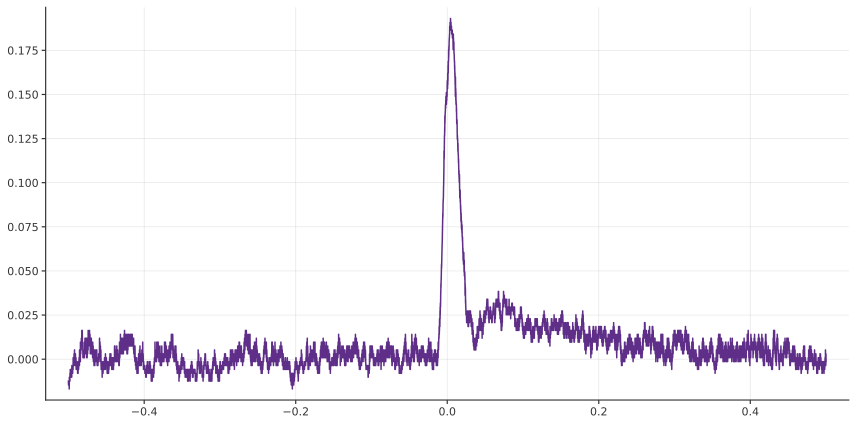

In [3]:
# Example usage - load and display the scope trace data
filepath = "/Users/andrew/Documents/PROGRAM_LOCAL/mid_ir_pcr_analysis/data/reset_dynamics/C2_015V_Newamps_80nmDev3_balun00001.txt"

# Load and display the full trace
trace_data = display_scope_trace(filepath)

# Example with cropping - remove 1 microsecond from each end
# This removes 1e-6 seconds from the start and 1e-6 seconds from the end
# trace_data_cropped = display_scope_trace(filepath, crop_left=1e-6, crop_right=1e-6)

# You can also use the time_window parameter for temporary zooming (doesn't modify the data)
# center_time = (trace_data.time_data.min() + trace_data.time_data.max()) / 2
# time_window = (center_time - 0.5e-6, center_time + 0.5e-6)
# trace_data_zoomed = display_scope_trace(filepath, time_window=time_window)

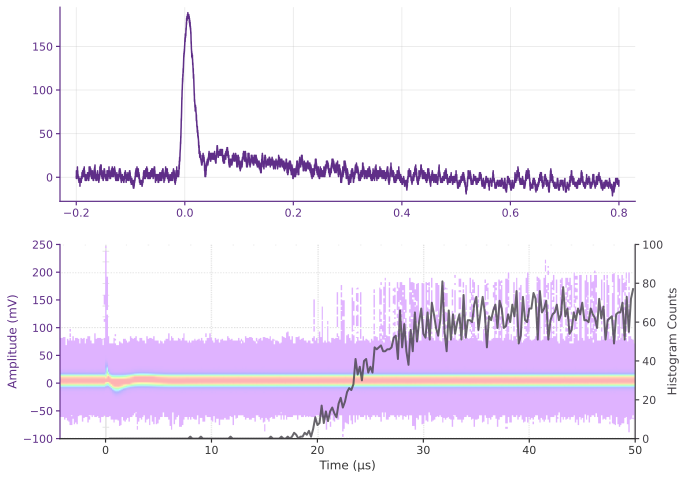

In [4]:
from PIL import Image
import os

def plot_top_panel(ax_top: Axes) -> None:
    """
    Plot the scope trace data on the top panel.
    
    Args:
        ax_top: matplotlib axes object for the top panel
    """
    # Load and process scope trace data
    filepath = "/Users/andrew/Documents/PROGRAM_LOCAL/mid_ir_pcr_analysis/data/reset_dynamics/C2_015V_Newamps_80nmDev3_balun00002.txt"
    trace_data_cropped = load_scope_trace(filepath, crop_left=0.0000048, crop_right=0.0000042)
    trace_data_cropped.amplitude_data *= 1000  # Convert to mV for plotting
    
    # Plot the trace
    plot_scope_trace(trace_data_cropped, ax=ax_top, use_cropped_data=True)
    
    # Style the axes
    ax_top.spines["left"].set_color(colors["dark_purple"])
    ax_top.spines["bottom"].set_color(colors["dark_purple"])
    ax_top.tick_params(axis="y", colors=colors["dark_purple"])
    ax_top.tick_params(axis="x", colors=colors["dark_purple"])

def plot_bottom_panel(ax_bottom: Axes, ax_bottom_secondary: Axes) -> None:
    """
    Plot the background image and histogram data on the bottom panel.
    
    Args:
        ax_bottom: matplotlib axes object for the bottom panel (primary y-axis)
        ax_bottom_secondary: matplotlib axes object for the secondary y-axis
    """
    # Set up the primary axis limits and background
    ax_bottom.set_ylim(-100, 250)
    ax_bottom.set_xlim(-4.3, 50)
    
    # Load and add background image
    filepath = "../data/reset_dynamics/C2_015V_Newamps_80nmDev3_balun00002.txt"
    image_path = os.path.join(os.path.dirname(filepath), "scope_trace.tif")
    
    def add_image_background(
        ax: Axes,
        image_path: str,
        crop_left: int = 0,
        crop_right: int = 0,
        crop_top: int = 0,
        crop_bottom: int = 0,
        alpha: float = 0.3,
    ):
        """Add a cropped image as background to the plot."""
        if os.path.exists(image_path):
            img = Image.open(image_path)
            width, height = img.size
            
            # Apply cropping
            left = crop_left
            top = crop_top
            right = width - crop_right
            bottom = height - crop_bottom
            
            img_cropped = img.crop((left, top, right, bottom))
            
            # Get current axis limits
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            
            # Display the image as background
            ax.imshow(img_cropped, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], 
                     aspect='auto', alpha=alpha, zorder=0)
            
            # Restore the axis limits
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
        else:
            print(f"Image not found: {image_path}")
    
    # Add background image with cropping
    add_image_background(ax_bottom, image_path, 
                        crop_left=370, crop_right=10, crop_top=129, crop_bottom=255, alpha=0.3)
    
    # Load and combine histogram data
    with open("../data/reset_dynamics/hist_data_test_600sec_1.66thermal.json") as f:
        hist_data = pd.read_json(f)
        x = np.array(hist_data["x_axis_ps"])/1e6  # Convert picoseconds to microseconds
        y = np.array(hist_data["histogram_counts"])
    
    with open("../data/reset_dynamics/hist_data_test_600sec_1.66thermal_2.json") as f:
        hist_data = pd.read_json(f)
        y = y + np.array(hist_data["histogram_counts"])
    
    # Plot histogram data on secondary y-axis
    crop = 250
    ax_bottom_secondary.plot(
        x[crop:], y[crop:], color=colors["black"], linewidth=2, zorder=10, alpha=0.8
    )
    
    # Style the secondary y-axis
    ax_bottom_secondary.set_ylabel("Histogram Counts", color=colors["black"], fontsize=12)
    ax_bottom_secondary.tick_params(axis="y", labelcolor=colors["black"])
    ax_bottom_secondary.set_xlim(-4.3, 50)
    ax_bottom_secondary.set_ylim(0, 100)
    
    # Style the spines
    ax_bottom_secondary.spines['right'].set_visible(True)
    ax_bottom_secondary.spines['right'].set_color(colors['black'])
    ax_bottom_secondary.spines['left'].set_visible(False)
    ax_bottom_secondary.tick_params(axis="y", colors=colors["black"])
    
    # Style the primary y-axis
    ax_bottom.spines["left"].set_visible(True)
    ax_bottom.spines['left'].set_color(colors['dark_purple'])
    ax_bottom.tick_params(axis="y", colors=colors["dark_purple"])
    ax_bottom.set_ylabel("Amplitude (mV)", color=colors["dark_purple"], fontsize=12)
    ax_bottom.set_xlabel("Time (μs)", fontsize=12)



# Create the figure and axes
fig = plt.figure(figsize=(8, 6))
bottom, top = bisect([0, 0, 1, 1], direction="horiz", offset=0.5, spacing=0.10)
ax_top = fig.add_axes(top)
ax_bottom = fig.add_axes(bottom)
ax_bottom_secondary = ax_bottom.twinx()

# Plot both panels
plot_top_panel(ax_top)
plot_bottom_panel(ax_bottom, ax_bottom_secondary)

plt.show()


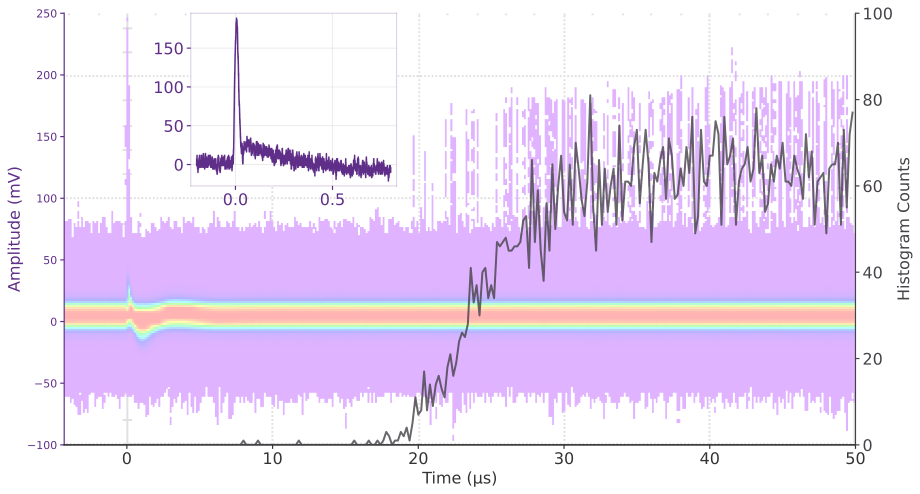

In [5]:
fig = plt.figure(figsize=(11, 6))
ax_main = fig.add_axes([0,0,1,1])

ax_main_secondary = ax_main.twinx()

ax_inset = ax_main.inset_axes([0.16, 0.6, 0.26, 0.4], transform=ax_main.transAxes)

plot_bottom_panel(ax_main, ax_main_secondary)

ax_inset.spines["right"].set_visible(True)
ax_inset.spines["top"].set_visible(True)
# make purple


alpha = 0.2
ax_inset.spines["right"].set_color(colors["dark_purple"])
ax_inset.spines["right"].set_alpha(alpha)
ax_inset.spines["top"].set_color(colors["dark_purple"])
ax_inset.spines["top"].set_alpha(alpha)
ax_inset.spines["left"].set_alpha(alpha)
ax_inset.spines["bottom"].set_alpha(alpha)

# ax_inset.xaxis.label.set_fontsize(15)
# not the label, but the numbers
ax_inset.tick_params(axis='x', labelsize=16)
ax_inset.tick_params(axis='y', labelsize=16)


ax_main.tick_params(axis='x', labelsize=16)
ax_main.xaxis.label.set_fontsize(16)

ax_main_secondary.tick_params(axis='y', labelsize=16)
ax_main_secondary.yaxis.label.set_fontsize(16)

ax_main.set_xlabel("Time (μs)", fontsize=16)
ax_main.set_ylabel("Amplitude (mV)", fontsize=16)

plot_top_panel(ax_inset)

plt.savefig("../out/scope_trace.pdf")
plt.savefig("../out/scope_trace.png")
